Let's look at some iron ore data

In [1]:
import pandas
import seaborn
import matplotlib.pyplot as plt
import os
import numpy as np
seaborn.set()

df = pandas.read_csv(os.path.abspath('iron_ore_study.csv'))

# Splits from oscar Fe>60%, SiO2<9, Al2O3<2, P<0.08
split_points = [
    ('FE', 60, [False, True]),
    ('SIO2', 9, [True, False]),
    ('AL2O3', 2, [True, False]),
    ('P', 0.08, [True, False]),  
]

# It's ore if everything is True
df['is_ore'] = np.vstack([
    pandas.cut(df[elem], bins=[0, split, 100], labels=is_ore)
    for elem, split, is_ore in split_points
]).sum(axis=0) == 4

# Take a look
seaborn.pairplot(df.iloc[::5], hue='is_ore', plot_kws={'alpha': 0.5})

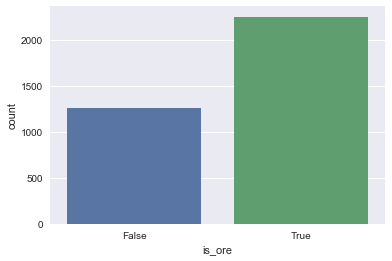

In [2]:
seaborn.countplot('is_ore', data=df)

Plot our x data

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


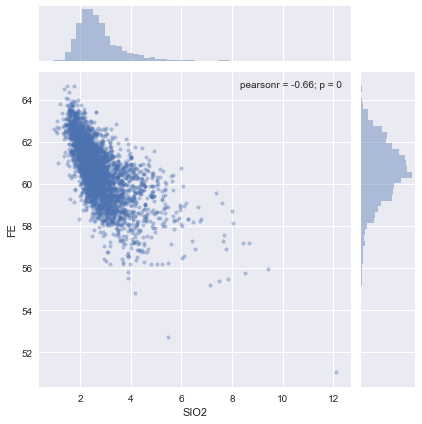

In [3]:
seaborn.jointplot('SIO2', 'FE', df, joint_kws={'alpha': 0.4, 'marker': '.'})

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


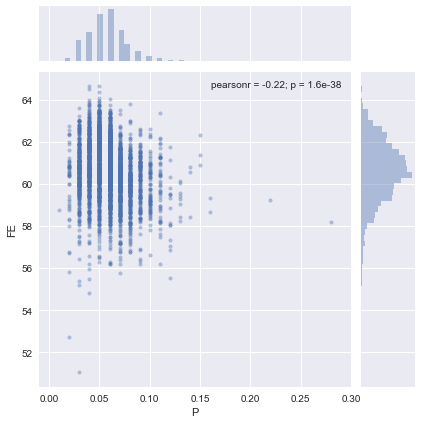

In [4]:
seaborn.jointplot('P', 'FE', df, joint_kws={'alpha': 0.4, 'marker': '.'})

## Logistic regression

You can think of the logistic function as a function that takes a real number (as comes out of the linear regression) and 'squashes' it into a 0, 1 label. It's defined as

$$
g(z) = \frac{1}{1 + e^{-z}}
$$

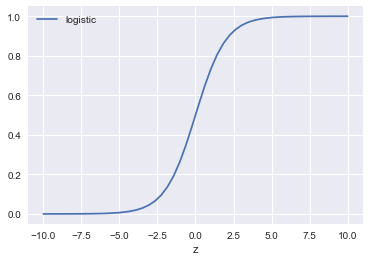

In [5]:
def logistic(z):    
    return 1 / (1 + np.exp(-z))

zs = np.linspace(-10, 10)
logistic_data = pandas.DataFrame( 
    {'z': zs, 'logistic': logistic(zs)}
)
logistic_data.plot('z', 'logistic')

If we can generate a linear model fit with one parameter - call it $f$:

$$
z = f(x) = a + b x
$$

where $a$ is the intercept, $b$ the coefficient and $x$ is the input features. Then we get label predictions

$$
\mathrm{label} = g(f(x)) > threshold
$$

## Problem

Let's pretend we have a crappy sensor which only measures Al. Can we still make good predictions of ore/not ore using just this feature?

We should look at transforming our aluminium data so that we go from (0, inf) -> (-inf, inf). We'll do this in a hacky sense by using a log function but we should really use a log-ratio transform here!

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


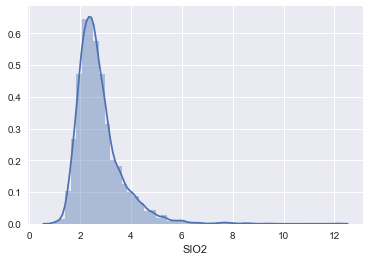

In [15]:
seaborn.distplot(df['SIO2'])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


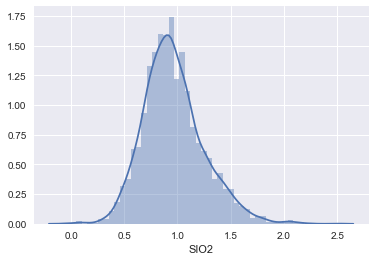

In [16]:
seaborn.distplot(np.log(df['SIO2']))

We'll do this using a scikit-learn pipeline - this lets us chain transformations and predictions into one object which makes life a lot easier.

In [17]:
from sklearn import preprocessing, pipeline, linear_model

# Make up our pipeline where we transform the aluminium first to make it more gaussian!
regressor = pipeline.Pipeline([
    ('transform', preprocessing.FunctionTransformer(np.log, validate=True)),
    ('model', linear_model.LogisticRegression())
])

Next we map the data into the `y ~ f(X)` format that scikit-learn wants

In [26]:
X = df[['AL2O3']]
y = df['is_ore']

Now fitting the model is as simple as

In [27]:
regressor.fit(X, y)

Pipeline(memory=None,
     steps=[('transform', FunctionTransformer(accept_sparse=False, func=<ufunc 'log'>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=True)), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

Once we've fitted the model we can make predictions straight away

In [28]:
predict_df = pandas.DataFrame(
    {'test_al2o3_values': [0.5, 1, 2, 3, 4]} # Are these values ore?
)  
regressor.predict(predict_df)

array([ True,  True, False, False, False])

To see what's going on in a bit more depth, we can pull the coefficients out of the scikit-learn pipeline

In [29]:
model = regressor.named_steps.model
model.intercept_, model.coef_

(array([2.46029206]), array([[-5.72109219]]))

and rewrite our logistic function to include the linear model

In [30]:
def logistic(regressor, X):
    """
    Plot our logistic model given input values x
    
    We're doing this so that we can see the output of the logistic function - normally
    you'd just do `regressor.predict(x)` to get actual 1, 0 labels for your data.
    
    Parameters:
        regressor - a fitted logistic regression pipeline
        x - the values to evaulate the function at
    """
    # We can pull the model and transforms from our pipeline
    model = regressor.named_steps.model
    tf = regressor.named_steps.transform
    
    # Next we replay the steps in the pipeline to make a prediction
    z = model.intercept_ + model.coef_[0][0] * tf.transform(X)
    return 1 / (1 + np.exp(-z)).ravel()

Now we can evaulate our logistic function for our test values

In [31]:
logistic(regressor, predict_df)

array([0.99838346, 0.92131084, 0.1816413 , 0.02135318, 0.00419012])

With these in hand lets generate some plots

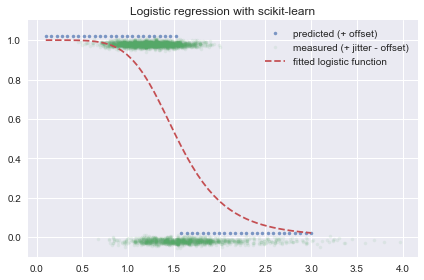

In [33]:
f, ax = plt.subplots(1, 1)

# Some aluminium values to predict from
al_compositions = pandas.DataFrame(
    {'test_al2o3_values': np.linspace(0.1, 3)}
)

# An offset to stop everything plotting on top of everything else
offset = 0.02

# shows predictions given contents
predictions = regressor.predict(al_compositions)
ax.plot(al_compositions, predictions + offset, '.', alpha=0.7, label='predicted (+ offset)')  

# shows measured values plus jitter
jitter = np.random.normal(scale=0.01, size=len(df))
ax.plot(df['AL2O3'], df['is_ore'] + jitter - offset, '.', alpha=0.1, label='measured (+ jitter - offset)')

# shows logistic function fitted from regressor
ax.plot(al_compositions, logistic(regressor, al_compositions), '--', label='fitted logistic function')

# Generate the logistic curve showing the location of 
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.set_title('Logistic regression with scikit-learn')
f.tight_layout()

Try this using one of the other variables!

## Measuring model performance

We don't get everything right! How can we get a feeling for the model performance? What are some of the issues that we might need to take into account?

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33)

Now we can train on just the training set, predict on the test set and see how we do!

In [37]:
regressor.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('transform', FunctionTransformer(accept_sparse=False, func=<ufunc 'log'>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=True)), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [38]:
y_predict = regressor.predict(X_test)

In [40]:
results = pandas.DataFrame({
    'AL2O3': X_test['AL2O3'],
    'is_ore_actual': y_test,
    'is_ore_predicted': y_predict,
    'count': 1
})
results

,AL2O3,is_ore_actual,is_ore_predicted,count
510,1.03,False,True,1
3092,1.42,True,True,1
168,1.06,False,True,1
2321,1.37,True,True,1
998,0.98,True,True,1
759,1.39,False,True,1
3362,1.49,True,True,1
432,1.19,True,True,1
934,1.55,False,False,1
2856,1.72,False,False,1


Now we can see the number of false positives and false negatives using pivot_table from last week

In [41]:
confusion = results.pivot_table(values='count', index='is_ore_actual', columns='is_ore_predicted', aggfunc='sum')
confusion

is_ore_predicted,False,True
is_ore_actual,,
False,236,153
True,98,668


and plot with seaborn

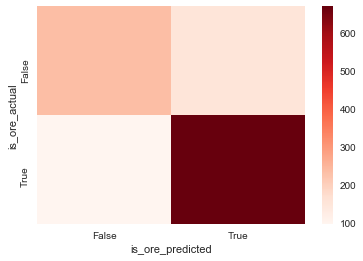

In [42]:
seaborn.heatmap(confusion, cmap='Reds')

Alternatively we can unstack the array into true and false negatives and positives

In [43]:
confusion.unstack()

is_ore_predicted  is_ore_actual
False             False            236
                  True              98
True              False            153
                  True             668
dtype: int64

And we can convert these values to fractions of the total

In [44]:
true_neg, false_neg, true_pos, false_pos = confusion.unstack() / confusion.unstack().sum()
true_neg, false_neg, true_pos, false_pos

(0.20432900432900433,
 0.08484848484848485,
 0.13246753246753246,
 0.5783549783549784)

When are true positives and false positives important?

## Threshold

We haven't done anything with the threshold yet - how should we pick the value for this?

We've already got a confusion matrix - we can take the ratio of the true_positive vs the false_positive rates and compare the two 

In [45]:
confusion

is_ore_predicted,False,True
is_ore_actual,,
False,236,153
True,98,668


In [46]:
correct = np.diag(confusion)
incorrect = np.diag(np.roll(confusion, 1, axis=1))
correct, incorrect

(array([236, 668], dtype=int64), array([153,  98], dtype=int64))

In [47]:
total_correct = correct.sum()
total_incorrect = incorrect.sum()
total_correct, total_incorrect

(904, 251)

And we can plot this for each threshold. We need a way of adjusting the class weights in the model. Scikit-learn doesn't let you specify a threshold directly but 

In [48]:
def fit_with_class_threshold(threshold):
    "Fit a logistic regression to get an ROC value for a given threshold"
    # Transform our threshold into class weights
    class_weights = {True: threshold, False: 1 - threshold}
    
    # Make a regressor
    regressor = pipeline.Pipeline([
        ('transform', preprocessing.FunctionTransformer(np.log, validate=True)),
        ('model', linear_model.LogisticRegression(class_weight=class_weights))
    ])
    
    # Fit it
    regressor.fit(X_train, y_train)
    
    # Make some predictions, see how we did
    results = pandas.DataFrame({
        'AL2O3': X_test['AL2O3'],
        'is_ore_actual': y_test,
        'is_ore_predicted': regressor.predict(X_test),
        'count': 1
    })
    confusion = results.pivot_table(
        values='count', 
        index='is_ore_actual', 
        columns='is_ore_predicted', 
        aggfunc='sum')
    true_neg, false_neg, true_pos, false_pos = confusion.unstack()
    correct = np.diag(confusion)
    incorrect = np.diag(np.roll(confusion, 1, axis=1))
    
    # Return results as a dictionary
    return {
        'threshold': threshold,
        'total_correct': correct.sum(), 
        'total_incorrect': incorrect.sum(), 
        'true_negative': true_neg,
        'false_negative': false_neg,
        'true_positive': true_pos,
        'false_positive': false_pos
    }

Now we can generate results using our metric

In [49]:
fit_with_class_threshold(0.1)

{'threshold': 0.1,
 'total_correct': 483,
 'total_incorrect': 672,
 'true_negative': 384,
 'false_negative': 667,
 'true_positive': 5,
 'false_positive': 99}

In [50]:
fit_with_class_threshold(0.9)

{'threshold': 0.9,
 'total_correct': 791.0,
 'total_incorrect': nan,
 'true_negative': 25.0,
 'false_negative': nan,
 'true_positive': 364.0,
 'false_positive': 766.0}

Now we can iterate over all our thresholds and see what does the best

In [51]:
results = pandas.DataFrame.from_records(
    [fit_with_class_threshold(t) for t in np.linspace(0.1, 0.9)],
    index='threshold'
)
results.head()

,false_negative,false_positive,total_correct,total_incorrect,true_negative,true_positive
threshold,,,,,,
0.100000,667.0,99.0,483.0,672.0,384.0,5.0
0.116327,633.0,133.0,511.0,644.0,378.0,11.0
0.132653,604.0,162.0,538.0,617.0,376.0,13.0
0.148980,575.0,191.0,564.0,591.0,373.0,16.0
0.165306,552.0,214.0,582.0,573.0,368.0,21.0


We'll generate a few plots 

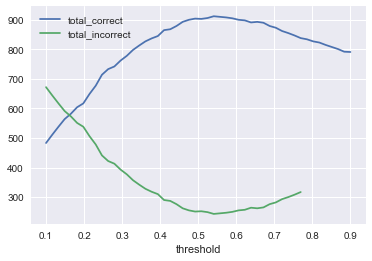

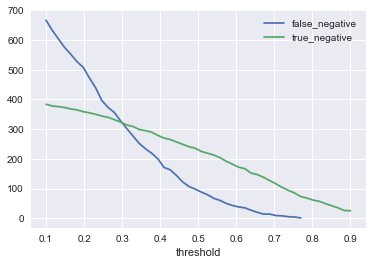

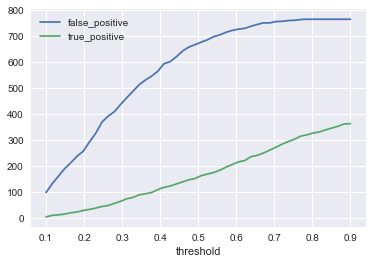

In [52]:
results.plot(y=['total_correct', 'total_incorrect'])
results.plot(y=['false_negative', 'true_negative'])
results.plot(y=['false_positive', 'true_positive'])

## Extension - modelling with statsmodels

For what it's worth we can also generate these using statsmodels

In [ ]:
import statsmodels.api as sm
from numpy import log

We have to handle preprocessing ourselves 

In [ ]:
from statsmodels.tools import add_constant

def preprocess(x):
    "Our preprocessing pipeline for Al2O3"
    return add_constant(np.log(x)) # add_constant adds an intercept to the fit

Statsmodels uses stats jargon 
- endog -> endogenous variable -> y
- exog -> exogenous variable -> X

In [ ]:
endog = df.is_ore
exog = preprocess(df['AL2O3'])

Fitting the model is pretty similar though

In [ ]:
model = sm.Logit(endog, exog)
results = model.fit()
results.summary()

Statsmodels does a bit more statistical testing/automated confidence intervals for us at the cost of having to manage crossvalidation etc ourselves. Depending on what you're trying to achieve this could be a viable way to go.

As before we can immediately make some predictions - statsmodels gives us the value of the logistic function

In [ ]:
preds = model.predict(results.params, preprocess(test_al_values))
preds

In [ ]:
preds > 0.5

and compare to scikit-learn

In [ ]:
regressor.predict(test_al_values.reshape(-1, 1))

We can also compare the logistic values get slightly different answers here - probably down to the solver used under the hood

In [ ]:
print(' statsmodels:', model.predict(results.params, preprocess(test_al_values)))
print('scikit-learn:', logistic(regressor, test_al_values))

We can generate the same plot again though

In [ ]:
f, ax = plt.subplots(1, 1)

# Some aluminium values to predict from
al_compositions = np.linspace(0.1, 3)

# An offset to stop everything plotting on top of everything else
offset = 0.02

# shows predictions given contents
predictions = model.predict(results.params, preprocess(al_compositions)) > 0.5
ax.plot(al_compositions, predictions + offset, '.', alpha=0.7, label='predicted (+ offset)')  

# shows measured values plus jitter
jitter = np.random.normal(scale=0.01, size=len(df))
ax.plot(df['AL2O3'], df['is_ore'] + jitter - offset, '.', alpha=0.1, label='measured (+ jitter - offset)')

# shows logistic function fitted from regressor
ax.plot(al_compositions, model.predict(results.params, preprocess(al_compositions)), '--', label='fitted logistic function')

# Generate the logistic curve showing the location of 
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.set_title('Logistic regression with statsmodels')
f.tight_layout()